Install Desired packages first, lavis requires restarting session so better to restart first before proceeding.

In [1]:
!pip install chromadb
!pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.0 MB/s eta 0:00:00
 

Imports

In [1]:
import chromadb
import tarfile
import pandas as pd
from tqdm import tqdm
from PIL import Image
from IPython.display import display, HTML
from base64 import b64encode
from google.colab import drive

import torch
from torch import cuda

from lavis.models import model_zoo
from lavis.models import load_model_and_preprocess

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/usr/local/lib/python3.10/dist-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


Mount google drive to access datasets, should be replaced with paths relative to docker image.

In [2]:
drive.mount('/gdrive', force_remount=True)
%ls /gdrive

project_dir="/gdrive/MyDrive/Interview Kickstart/MLSwitchup/Capstone/ShopTalk"
datasets_dir = project_dir + '/datasets'
embeddings_dir = datasets_dir + '/embeddings'

Mounted at /gdrive
MyDrive/  Othercomputers/


Read the EDA processed ABO listing dataset

In [3]:
abo_listing_df = pd.read_pickle(datasets_dir + '/abo-listings-final-draft.pkl')
abo_listing_df.head()

,brand,bullet_point,color,fabric_type,item_name,item_weight,model_name,product_type,style,main_image_id,other_image_id,country,marketplace,domain_name,material,item_keywords,pattern,model_year,product_description,finish_type
item_id,,,,,,,,,,,,,,,,,,,,
B0857LSVB7,Amazon Brand - Solimo,"[Snug fit for Samsung Galaxy J2 Ace, with perf...",Multicolor,NaN,Amazon Brand - Solimo Designer Lion UV Printed...,50,Samsung Galaxy J2 Ace,CELLULAR PHONE CASE,NaN,81-DuD5XzmL,"[61+woWTqkwL, 61SE4RTPjdL]",IN,Amazon,amazon.in,Silicon,"[Back Cover, Designer Case, Designer Lion Mobi...",NaN,NaN,NaN,NaN
B07C5FF8QS,AmazonBasics,"For best performance, follow the manufacturer'...",NaN,NaN,"AmazonBasics High Mileage Motor Oil, Synthetic...",NaN,NaN,AUTO OIL,High Mileage - Synthetic Blend,81YCp3dcurL,"[817GQ6xx-QL, 81Vr9poKgCL]",SG,Amazon,amazon.sg,NaN,"[oil, mobil 1, penzoil, castrol gtx, 5W-20, 5W...",10W-30,NaN,NaN,NaN
B07TG425LX,Amazon Brand - Solimo,[3D Printed Hard Back Case Mobile Cover for Hu...,Others,NaN,Amazon Brand - Solimo Designer Semi Circle Tex...,50,Huawei P9 lite,CELLULAR PHONE CASE,NaN,71ZoXfUr-sL,"[81IiaAkE6UL, 61Xce1Hq7DL, 61ATVyzpLKL, 61oI69...",IN,Amazon,amazon.in,NaN,"[mobile cover, back cover, mobile case, phone ...",NaN,NaN,NaN,NaN
B07LCHFZCW,Amazon Go,NaN,NaN,NaN,"Amazon Kitchen, Cajun Style Potato Salad, 7.2 oz",NaN,NaN,GROCERY,NaN,61bCuBtuZ4L,"[61njweKAz7L, 61UEtH+yC3L]",US,Amazon,amazon.com,NaN,NaN,NaN,NaN,NaN,NaN
B077W2YX72,Wickedly Prime,"[One 44-ounce plastic tub, Contains wheat, pea...",NaN,NaN,"Wickedly Prime Peanut Butter-Filled Pretzels, ...",2.8,NaN,GROCERY,NaN,71QbaO8qZIL,"[51M39MBAwDL, 71F6YzH37XL, 71d7-4rSVlL, 61ucPj...",US,AmazonGo,amazon.com/go,NaN,"[pretzels, peanut butter, peanut butter pretze...",NaN,NaN,NaN,NaN


Prepare image dataset

In [4]:
!wget -nc https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar

tar = tarfile.open("abo-images-small.tar")
tar.extractall()
tar.close()

!gunzip -f 'images/metadata/images.csv.gz'

images_df = pd.read_csv('images/metadata/images.csv').set_index('image_id')
images_df.head()

--2024-12-27 08:21:34--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.216.62.177, 52.217.80.236, 16.15.178.227, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.216.62.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253381120 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  14.9MB/s    in 3m 25s  

2024-12-27 08:25:01 (15.1 MB/s) - ‘abo-images-small.tar’ saved [3253381120/3253381120]



,height,width,path
image_id,,,
010-mllS7JL,106,106,14/14fe8812.jpg
01dkn0Gyx0L,122,122,da/daab0cad.jpg
01sUPg0387L,111,111,d2/d2daaae9.jpg
1168jc-5r1L,186,186,3a/3a4e88e6.jpg
11RUV5Fs65L,30,500,d9/d91ab9cf.jpg



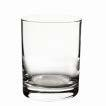

In [5]:
# source: https://stackoverflow.com/questions/49478791/how-can-i-open-images-in-a-google-colaboratory-notebook-cell-from-uploaded-png-f
def get_image_html(image_id, width=None, height=None):
    mime_type = None
    path_to_image = 'images/small/' + images_df.loc[image_id, 'path']
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    return "<img src='%s' %s%s>" % (data_url, width_str, height_str)

display(HTML(get_image_html('010-mllS7JL')))

Helper Method to display a product listing

Column,Value
brand,Amazon Brand - Solimo
bullet_point,"Snug fit for Mobile, with perfect cut-outs for volume buttons, audio and charging portsCompatible with Samsung Galaxy Note 10 PlusEasy to put & take off with perfect cutouts for volume buttons, audio & charging ports.Stylish design and appearance, express your unique personality.Extreme precision design allows easy access to all buttons and ports while featuring raised bezel to life screen and camera off flat surface.No warranty"
color,multi-colored
fabric_type,nan
item_name,Amazon Brand - Solimo Designer Heart Design 3D Printed Hard Back Case Mobile Cover for Samsung Galaxy Note 10 Plus
item_weight,50
model_name,Samsung Galaxy Note 10 Plus
product_type,CELLULAR PHONE CASE
style,nan
main_image_id,

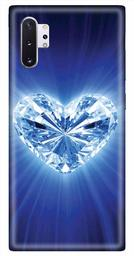
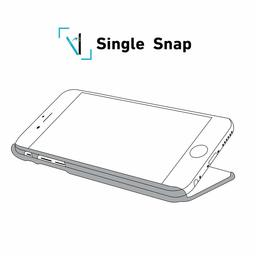
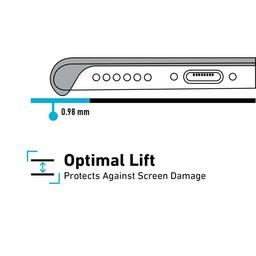
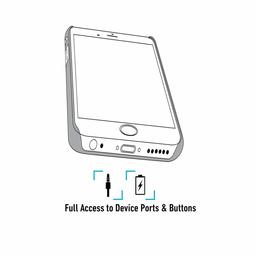

In [6]:
def display_product(item_id):
  html_string = "<table border='1'>"
  html_string += "<tr><th>Column</th><th>Value</th></tr>"

  row = abo_listing_df.loc[item_id]
  for col_name, value in row.items():
    if col_name == 'main_image_id':
      value = get_image_html(value)
    elif col_name == 'other_image_id':
      value = "".join(get_image_html(image_id) for image_id in value)
    elif isinstance(value, list):
      list_html = "<ul>" + "".join(f"<li>{item}</li>" for item in value) + "</ul>"
      value = list_html
    html_string += f"<tr><td>{col_name}</td><td>{value}</td></tr>"

  html_string += "</table>"
  display(HTML(html_string))

random_row_key = abo_listing_df.sample(n=1).index[0]
display_product(random_row_key)

In [7]:
embeddings_abo_df = pd.read_pickle(embeddings_dir + '/embeddings_abo.pkl')
embeddings_abo_df.head()

,image_id,item_id,embedding
0,81-DuD5XzmL,B0857LSVB7,"[-0.52192634, -0.46416232, 0.005269423, -0.792..."
1,61+woWTqkwL,B0857LSVB7,"[-0.18547179, -0.6788964, 0.10444248, -0.36741..."
2,61SE4RTPjdL,B0857LSVB7,"[-0.009377651, -0.60804415, 0.0016542991, -0.3..."
3,81YCp3dcurL,B07C5FF8QS,"[0.80878174, -0.4682043, 1.0941213, -0.8250118..."
4,817GQ6xx-QL,B07C5FF8QS,"[1.0564034, -0.16991387, 0.9090485, -0.3455055..."


In [8]:
embeddings_abo_df['product_type'] = embeddings_abo_df['item_id'].apply(lambda x: abo_listing_df.loc[x, 'product_type'])
embeddings_abo_df['product_type'].value_counts()

,count
product_type,
CELLULAR PHONE CASE,280832
SHOES,53651
GROCERY,29867
HOME,10933
CHAIR,9200
...,...
TABLETOP GAME,1
GPS OR NAVIGATION SYSTEM,1
NECKTIE,1


In [9]:
sample_fraction = 0.5  # % of Samples from each category

def dynamic_sample(group):
  sample_size = len(group) if len(group) <= 5 else int(len(group) * sample_fraction)
  sample_size = min(sample_size, 100)
  return group.sample(sample_size)

embeddings_abo_df = embeddings_abo_df.groupby('product_type', group_keys=False).apply(dynamic_sample)
embeddings_abo_df['product_type'].value_counts()

,count
product_type,
ACCESSORY,100
EDIBLE OIL VEGETABLE,100
DRESSER,100
NUTRITIONAL SUPPLEMENT,100
NUT BUTTER,100
...,...
TABLETOP GAME,1
GPS OR NAVIGATION SYSTEM,1
AMAZON BOOK READER ACCESSORY,1


In [10]:
chroma_client = chromadb.PersistentClient(datasets_dir + "/abolisting.db")
#chroma_client.delete_collection(name="abolistings")
collection = chroma_client.get_or_create_collection(name="abolistings")

In [11]:
batchsize = 1000
for i in tqdm(range(0, len(embeddings_abo_df), batchsize)):
  i_end = min(i+batchsize, len(embeddings_abo_df))
  batch = embeddings_abo_df.iloc[i:i_end]
  batch['image_id'] = batch['image_id'].fillna('')
  collection.add(
      embeddings=batch['embedding'].tolist(),
      ids=(batch['item_id'] + "#" + batch['image_id']).tolist())

100%|██████████| 24/24 [00:50<00:00,  2.11s/it]


In [12]:
collection.count()

23170

In [13]:
results = collection.query(
    query_embeddings=[embeddings_abo_df.iloc[0]["embedding"]],
    n_results=5
)

print(embeddings_abo_df.iloc[0])
print(results)

image_id                                              71W44oMfVQL
item_id                                                B08247SBF1
embedding       [-0.17300771, -0.3557783, -0.067304805, -0.006...
product_type                                            ACCESSORY
Name: 332659, dtype: object
{'ids': [['B08247SBF1#71W44oMfVQL', 'B07MC49BWL#71N4ADisrSL', 'B071W6RGYF#81piwTWkSGL', 'B07PGB9BZZ#71jQ1IvANhL', 'B082SNDHV6#61mx1piY6HL']], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[None, None, None, None, None]], 'distances': [[0.0, 48.00030517578125, 51.460784912109375, 56.805667877197266, 67.23912811279297]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


In [14]:
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [15]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=False, device=device)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.89G/1.89G [01:25<00:00, 23.6MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 712M/712M [00:32<00:00, 22.9MB/s]


In [16]:
model = torch.load(project_dir + "/models/blip-2-abo-trained-2epochs.pt", map_location=device)
model = model.float()
model = model.to(device)
model.eval()

Blip2Qformer(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )


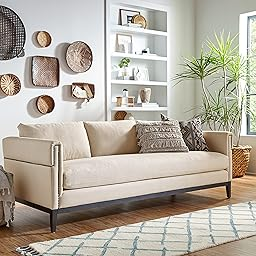

In [17]:
image = Image.open(datasets_dir + '/sofa.jpg')
display(image)

In [18]:
image = vis_processors["eval"](image).unsqueeze(0).to(device)
text = txt_processors["eval"]("Find similar sofa")

inputs = {"image": image, "text_input": text}

# find features of image and text target
multimodal_emb = model.extract_features(inputs).multimodal_embeds[0,0,:] # size (768)
print(multimodal_emb)

tensor([ 2.9439e-01,  1.4800e-01, -6.7374e-02,  1.8612e-01,  2.7427e-01,
         3.2090e-01, -6.3932e-02,  2.0459e-01,  1.4988e-01, -2.6333e-01,
        -4.8084e-01,  8.8927e-02,  2.6937e-01,  5.6051e-01,  1.1456e-01,
         2.6842e-01, -1.7918e-01, -2.5448e-01,  7.0350e-03, -1.7366e-01,
         4.4620e-01, -9.3783e-02, -4.2216e-01,  1.8814e-01,  3.7294e-01,
        -4.9688e-02,  4.9502e-01, -2.4155e-01,  1.6818e-01,  1.0511e-01,
         2.5919e-01,  2.7664e-01,  3.1012e-01,  1.6844e-01, -3.7405e-02,
        -2.5636e-01, -5.2580e-01,  6.7679e-01, -5.4962e-02, -3.8515e-01,
        -2.8209e-01, -2.9550e-01,  5.8163e-01,  5.4113e-01,  3.5072e-01,
        -2.9499e-01, -1.1197e+00,  2.7281e-01, -4.1490e-02,  1.9339e-01,
         2.3313e-01,  3.7062e-01,  3.3800e-01,  2.1531e-01, -2.4309e-01,
         2.8459e-01, -3.5227e-01,  3.1074e-01,  8.2036e-02,  3.3421e-01,
         1.8270e-01,  2.0931e-01,  3.7315e-02, -3.5617e-02,  1.7922e-02,
         3.4692e-01, -2.7073e-02, -2.7693e-01,  3.7

In [19]:
results = collection.query(
    query_embeddings=[multimodal_emb.tolist()],
    n_results=5
)

print(results)

{'ids': [['B072PXBV6W#A1y7ZqfgtZL', 'B07B4D499R#91Os1O-baLL', 'B075X4VR52#91KW2xJXY5L', 'B07H8SSBVT#71cIeKTogjL', 'B07HZ61DWG#A1U92IToOQL']], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[None, None, None, None, None]], 'distances': [[34.512298583984375, 39.46807861328125, 42.936248779296875, 42.99803161621094, 44.270111083984375]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


Column,Value
brand,Rivet
bullet_point,"Pile: 90% Leather, 10% Cotton, No BackingImportedA soft-yet-durable blend of leather and cotton adds rugged texture to this otherwise simple, multicolored stripe rug. Hand-woven in India, this rectangular rug is the perfect addition to a modern room.Area rug features a textured stripe patternHand-woven with a leather/cotton blend fabricMedium, .65'' pile suits high-traffic, transitional indoor areasPair with a rug pad (sold separately)7'6"" x 9'6""Ships tightly rolled in a protective bag"
color,Beige & Silver
fabric_type,nan
item_name,"Amazon Brand – Rivet Leather and Metallic Faded Lines Rug, 7'6"" x 9'6"", Beige & Silver"
item_weight,60.0
model_name,nan
product_type,RUG
style,Transitional
main_image_id,

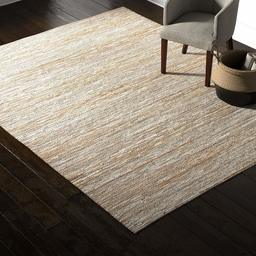
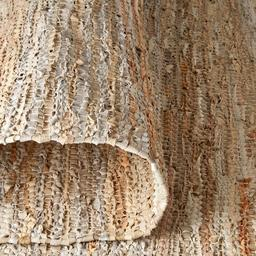
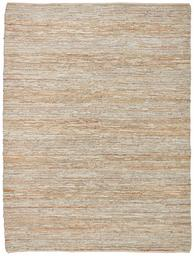
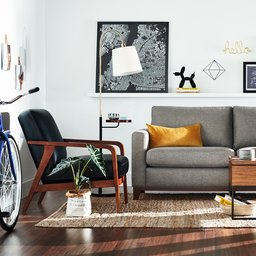
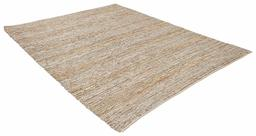
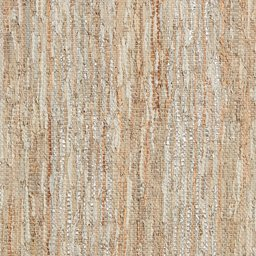

Column,Value
brand,Stone & Beam
bullet_point,"The classic English roll arm gives this cozy sofa a look ideal for a cottage or farmhouse décor. Sturdy construction, durable fabric and reversible cushions allow this piece to withstand years of fun with friends, family and pets.82""W x 43""D x 39""H; Seat Height: 21""H ; Seat Depth: 22""D; Seat Back Height: 37""H; Arm Height: 27""H; Front legs: 5.25""H; Back legs: 4""HPolypropylene fabric on hardwood pine frameEnglish roll arms combine with modern lines to blend with transitional or farmhouse décorSturdy frame, reversible cushions for durability; front-leg casters make it easy to moveEasy assembly in less than 15 minutes; just screw in legsFree returns for 30 days. 1-year warranty."
color,Light Blue
fabric_type,nan
item_name,"Amazon Brand – Stone & Beam Brandeberry Farmhouse Charles of London Sofa, 82""W, Light Blue"
item_weight,22
model_name,nan
product_type,SOFA
style,nan
main_image_id,

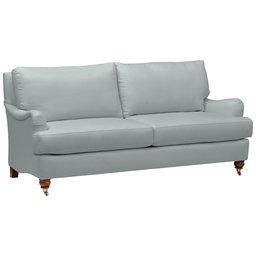
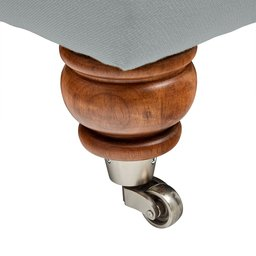
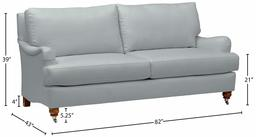
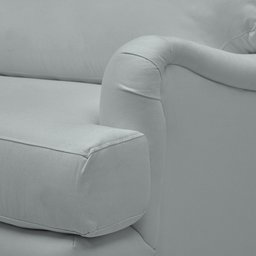
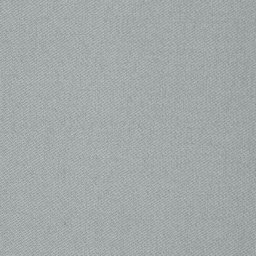
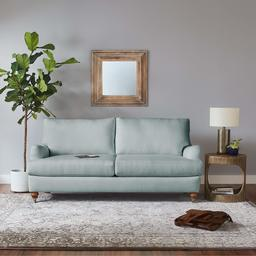

Column,Value
brand,Stone & Beam
bullet_point,"This item is made to order just for you69""W x 36""D x 31""HSolid wood frame and legs with 100% polyester upholstery.The tight, fixed back and removable/reversible cushions ensure durability and comfort.Treat yourself to luxury in this striking, vintage look loveseat. With solid wood legs in a dark walnut finish, plush velvet upholstery and a low, curved tufted back, it exudes opulence. Two removable/reversible seat cushions ensure many years of use.Assemble in 15 minutes or less. Vacuum or wipe with a soft, dry cloth.Free returns for 30 days. 3-year warranty."
color,Blue
fabric_type,Fabric
item_name,"Amazon Brand – Stone & Beam Leila Velvet Tufted Sofa, 69""W, Navy Blue"
item_weight,125
model_name,nan
product_type,HOME FURNITURE AND DECOR
style,nan
main_image_id,

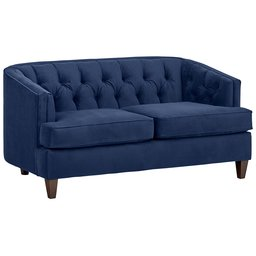
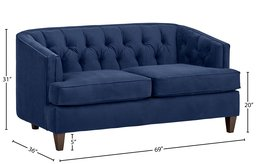
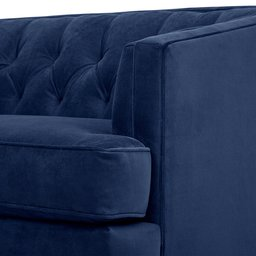
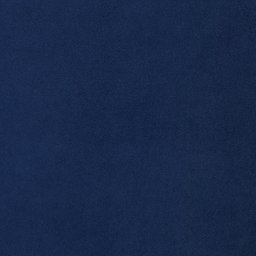
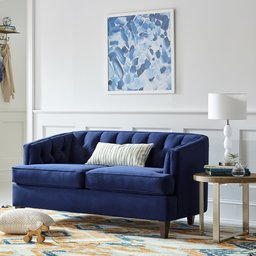

Column,Value
brand,
bullet_point,
color,
fabric_type,nan
item_name,Movian Douro
item_weight,nan
model_name,nan
product_type,SHELF
style,
main_image_id,

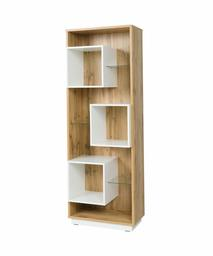
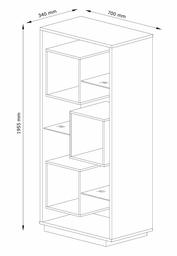
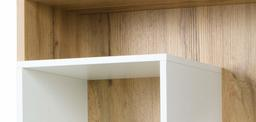
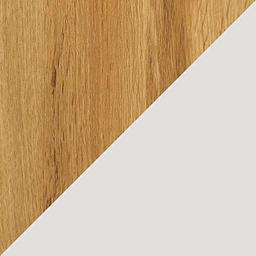
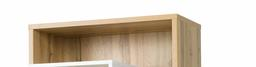
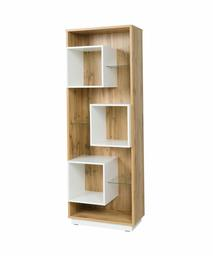
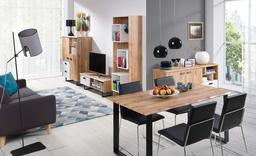
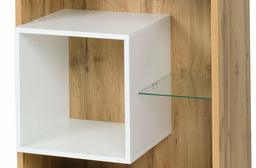
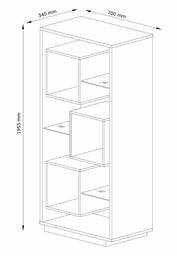
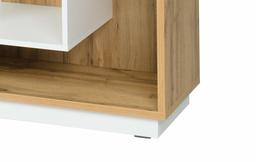

Column,Value
brand,Stone & Beam
bullet_point,"This sectional sofa boasts a smooth polyester-nylon blend that’s a dream to sit or lie on. This is the right-facing sofa component—put several pieces together to arrange your seating in a way that brings the most possible comfort to your living room.Sturdy wood frame with stain-resistant fabricAttached back and reversible seat cushions add lasting style.No assembly requiredFree returns for 30 days. 3-year warranty.This item is made to order just for youOverall: 75""W x 40""D x 36""H; seat height: 22""H; seat depth: 24""D; seat back height: 36""H; arm height: 24""H; leg height: 2.125""H"
color,Stone
fabric_type,"95% Polyester, 5% Nylon"
item_name,"Amazon Brand – Stone & Beam Bagley Sectional Component, Right-Facing Sofa, Fabric, 75""W, Stone"
item_weight,170
model_name,nan
product_type,SOFA
style,Transitional
main_image_id,

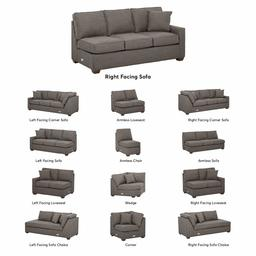
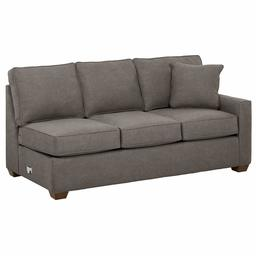
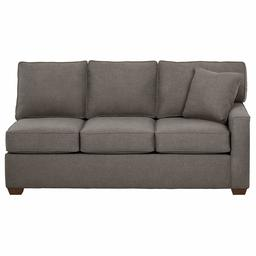
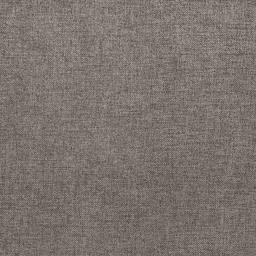
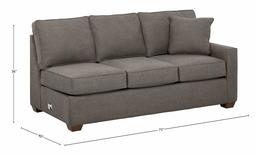
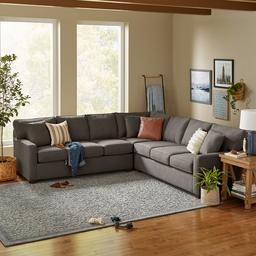
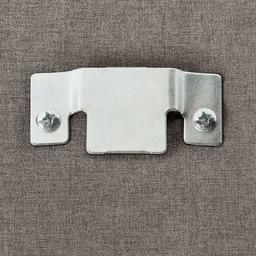

In [20]:
for id in results['ids'][0]:
  item_id, image_id = id.split('#')
  display_product(item_id)